In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/"
else:
    data_location = "../"

In [2]:
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

In [3]:
Experiment = namedtuple('Experiment', ['data', 'freq', 'model_config'])
experiments = [
    Experiment(
        data="air_passengers.csv",
        freq="MS",
        model_config={"seasonality_mode":"multiplicative"},
    ),
    Experiment(
        data="wp_log_peyton_manning.csv",
        freq="D",
        model_config={"n_changepoints": 50},
    ),
    Experiment(
        data="yosemite_temps.csv",
        freq="5min",
        model_config={"n_forecasts": 12, "n_lags": 36},
    ),
]

In [4]:
def run_experiment(e, plot=False):
    df = pd.read_csv(data_location + "example_data/" + e.data)
    print(" ---- running exp: {} (len: {}) ----".format(e.data, len(df)))
    folds = NeuralProphet(**e.model_config).crossvalidation_split_df(df, freq=e.freq, k=3, fold_pct=0.2, fold_overlap_pct=0.0)
    train, val = [], []
    for df_train, df_val in folds:
        m = NeuralProphet(**e.model_config)
        metrics_train = m.fit(df_train, freq=e.freq, plot_live_loss=False)
        metrics_val = m.test(df_val)
        train.append(metrics_train["MAE"].values[-1])
        val.append(metrics_val["MAE"].values[-1])
    if plot:
        future = m.make_future_dataframe(df_train, periods=len(df_val), n_historic_predictions=len(df_train))
        forecast = m.predict(future)
        fig = m.plot(forecast)
        plt.show()
    print("train MAE:", train)
    print("val MAE:", val)
    print("train MAE (avg):", sum(train)/len(train))
    print("val MAE (avg):", sum(val)/len(val))
    

 ---- running exp: air_passengers.csv (len: 144) ----


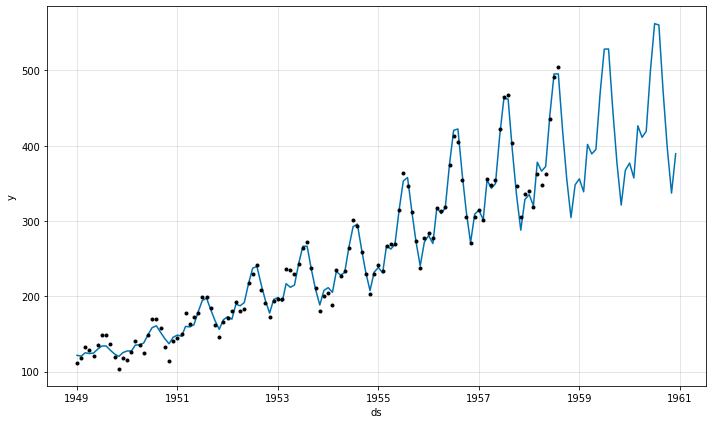

train MAE: [4.733074951171875, 5.357368816028941, 6.214755156944538]
val MAE: [26.009349822998047, 26.74343490600586, 27.628416061401367]
train MAE (avg): 5.435066308048452
val MAE (avg): 26.793733596801758
 ---- running exp: wp_log_peyton_manning.csv (len: 2905) ----


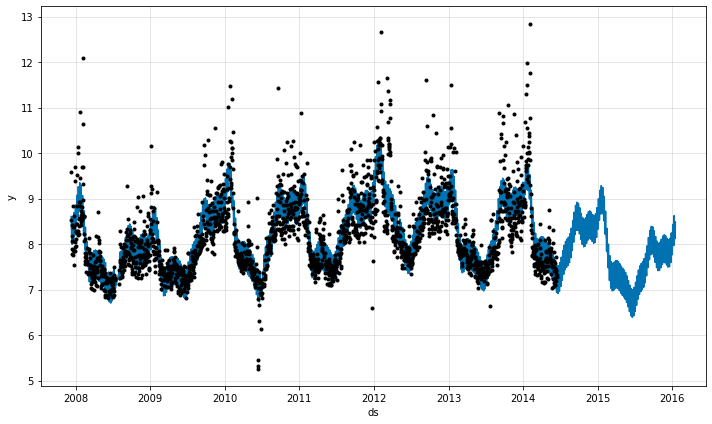

train MAE: [0.2750470902443753, 0.31487559866987286, 0.32930550262614083]
val MAE: [1.845394492149353, 0.46800923347473145, 0.32796308398246765]
train MAE (avg): 0.30640939718012966
val MAE (avg): 0.8804556032021841
 ---- running exp: yosemite_temps.csv (len: 18721) ----


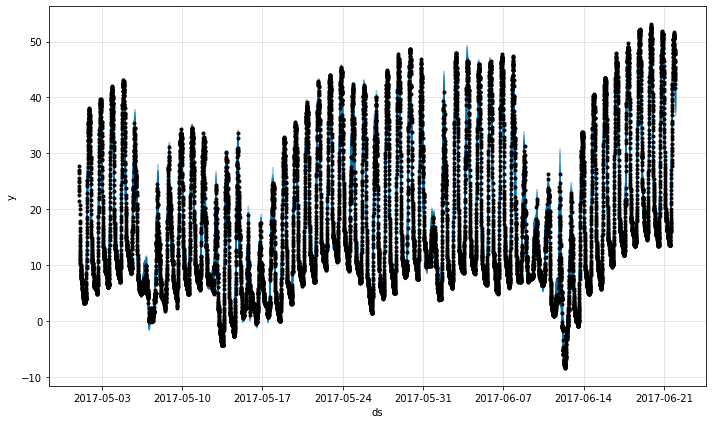

train MAE: [0.9475272831323557, 0.9570106588066535, 0.9385996977919336]
val MAE: [1.37901272254997, 1.1544153225894653, 2.261075582023858]
train MAE (avg): 0.947712546576981
val MAE (avg): 1.5981678757210975


In [5]:
for exp in experiments:
    run_experiment(exp, plot=True)